<a href="https://colab.research.google.com/github/armenbod/battersea_park/blob/main/runners_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Battersea Park Runners Problem

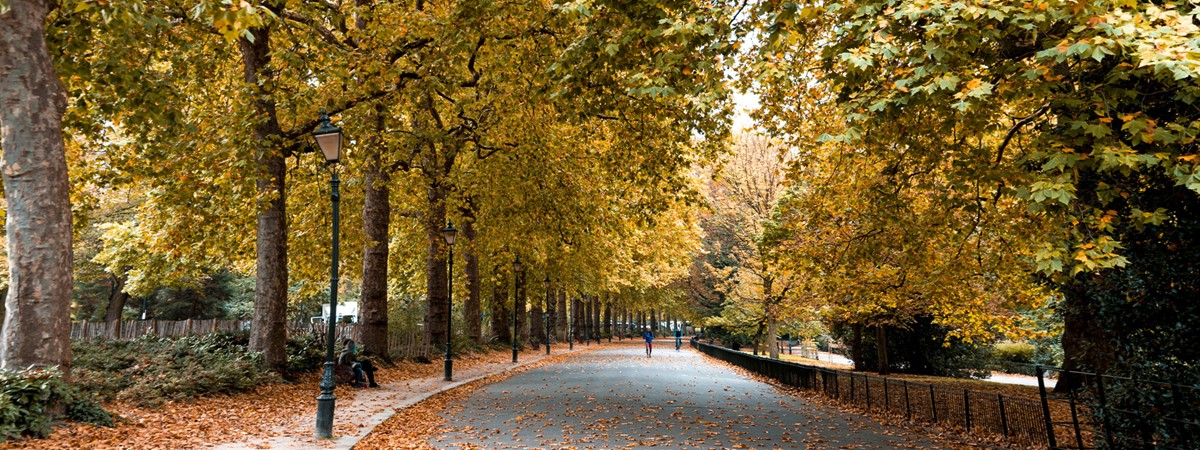

<br>

Code to accompany results found in Medium article. <br>
Link: to be included <br>
Image credits: [link](https://dandg.azureedge.net/cache/c/f/a/3/a/6/cfa3a6d306e67969e5aa6bf8fed7a8fcd1d6264b.jpg)
<br><br>

**Sections**



*   Define parameters & functions
*   Calculation
*   Simulation
*   Plots



In [ ]:
import math
import plotly.express as px
import numpy as np
import pandas as pd
from scipy import integrate
from typing import Union


## Define Parameters

In [ ]:

# L: Circuit distance (m)
L = 3000

# N: number of runners (in both directions)
N = 100

# MY_SPEED, alpha: My speed (m/s) and corresponding time taken to run circuit
MY_SPEED = 3.7
alpha = L/MY_SPEED

# MU: Average speed of a runner (men/woman), taken from https://caloriesburnedhq.com/average-running-speed/, converted to m/s
MU = 2.77165

# SIGMA: Standard deviation, m/s (sensible estimate)
SIGMA = 0.536

# n_steps : number of timesteps (for plotting purposes only)
n_steps = 11


## Define Functions

In [ ]:
def uniform(l : float):
  # Returns a uniform distribution between 0 - l

  return np.random.uniform(0, l)

def nd(mu : float, sigma : float):
  # Returns a normal distribution with parameters mu and sigma

  return np.random.normal(mu, sigma)

## Calculations

### Integrating joint pdf

In [ ]:
# Define the joint PDF function
def joint_pdf(x: float,
              y: float,
              mu: float,
              sigma: float,
              b: Union[int, float],
              a: Union[int, float] = 0) -> float:

    uniform_pdf = 1 / (b - a)
    normal_pdf = 1 / (sigma * (2 * np.pi) ** 0.5) * \
                 np.exp(-((y - mu) ** 2) / (2 * sigma ** 2))
    return uniform_pdf * normal_pdf


# Define the function to be integrated
def integrand(y, x):
    return joint_pdf(x, y, MU, SIGMA, L, 0)


In [ ]:

# Perform the double integration using the scipy integrate function
result, error = integrate.dblquad(integrand, 0, L, lambda x: -float('inf'), lambda x: (L - x)/alpha )

# Print the result
print("Probability that will pass runner:", result)
print(f'Expected passes = {round((N/2)*result, 2)} people')

# consider people going the other way
rate = (1/result)

print(f'Expect to pass {round(rate, 1)}x more people going the other way')

Probability that will pass runner: 0.2533549424978117
Expected passes = 12.67 people
Expect to pass 3.9x more people going the other way


### Running Simulation

In [ ]:
# Simulation function

def running_simulator(mu, sigma, l, my_speed, n, s, nlaps, decay=1) -> list:


  overtake_set = []
  overtaken_set = []

  # Start each simulation
  for j in range(s):
    overtake = 0
    overtaken = 0

    # Loop each runner
    for i in range(n):
      speed = nd(mu, sigma)
      dis = uniform(l)
      alpha = l/my_speed

      # Loop each lap
      for lap in range(1, nlaps + 1):
        dis += alpha * speed
        if dis < l:
          overtake += 1
        if dis >= l:
          dis = dis - l
          if dis > l:
            overtaken += 1

        # decay speed vs nlaps
        speed = speed * decay
        alpha = alpha / decay

    overtake_set.append(overtake)
    overtaken_set.append(overtaken)

  return overtake_set, overtaken_set


In [ ]:
# Run simulation

s = 5000
nlaps = 1


overtake_set, overtaken_set = running_simulator(MU, SIGMA, L, MY_SPEED, int(N/2), s, nlaps)

print(f'Simulation: expected passes = {round(np.mean(overtake_set), 2)} people')
print(f'Simulation: expected people overtaking me = {round(np.mean(overtaken_set), 2)} people')

Simulation: expected passes = 12.71 people
Simulation: expected people overtaking me = 0.13 people


## Plots

### Single lap arrow plot

In [ ]:
def arrow_annotate(xs : str,
                   xe : str,
                   ys : str,
                   ye : str,
                   color='red',
                   arrowwidth=0.5):

   return fig.add_annotation(ax = xs,
                      axref = 'x',
                      ay = ys,
                      ayref = 'y',
                      x = xe,
                      arrowcolor=color,
                      xref = 'x',
                      y = ye,
                      yref='y',
                      arrowwidth=arrowwidth,
                      arrowside='end',
                      arrowsize=2,
                      arrowhead = 1)

In [ ]:
# Generate dataframes for one lap

runners = []

# for each runner assign a starting position and velocity
for i in range(int(N/2)):
  runners.append((uniform(L), nd(MU, SIGMA)))


# Create
runners_df = pd.DataFrame(data={'n' : range(int(N/2)),
                                'd0' : [x[0] for x in runners],
                                'd1' : [x[0] + alpha*x[1] for x in runners]})

my_df = pd.DataFrame(data={'n' : [int(N/2)+1], 'd0' : [0], 'd1' : [L]})

In [ ]:

fig = px.scatter(runners_df, x='n', y='n')
fig = px.scatter(my_df, x='n', y='n')


# Generate arrows
for index, row in runners_df.iterrows():

    # Arrows for runners not overtaken
    if row['d1'] > L:
      arrow_annotate(row['d0'], row['d1'], row['n'], row['n'], color='black')

    # Arrows for runners overtaken
    else:
      arrow_annotate(row['d0'], row['d1'], row['n'], row['n'], color='red')

# My arrow
for index, row in my_df.iterrows():
  arrow_annotate(row['d0'], row['d1'], row['n'], row['n'], color='green', arrowwidth=1)

fig.update_traces(marker=dict(size=12, opacity=0))
fig.update_layout(title='Distance travelled in one lap for each n, Red: Overtaken by Me (Green)', showlegend=False)

fig.show()



### Single lap animation plot

In [ ]:
# Generate my dataframe for n_steps

mds = [0]

for t in range(1, n_steps + 1):
  d1 = alpha * MY_SPEED * t / n_steps
  mds.append(d1)

my_df_steps = pd.DataFrame(data={'n' : [(N/2)+1]*(n_steps + 1), 't' : range(0, n_steps +1), 'd0' : [0]*(n_steps + 1), 'd1' : mds, 'overtaken' : [2]*(n_steps + 1)})


In [ ]:
# Generate runners dataframe for n_steps

runners_df_steps = pd.DataFrame()

for n in range(int(N/2)):
  x = runners[n]
  ds = [x[0]]
  color = [0]
  for t in range(1, n_steps + 1):
    d1 = x[0] + alpha * x[1] * t / n_steps
    ds.append(d1)
    if d1 < mds[t]:
      color.append(1)
    else:
      color.append(0)


  r = pd.DataFrame(data={'n' : [n]*(n_steps + 1), 't' : range(0, (n_steps + 1) ), 'd0' : [x[0]]*(n_steps + 1), 'd1' : ds, 'overtaken' : color})
  runners_df_steps = pd.concat((runners_df_steps, r), axis=0)


In [ ]:
# Combine the two
df_steps = pd.concat((runners_df_steps, my_df_steps), axis=0)

In [ ]:
# Plot animation

fig = px.scatter(df_steps, x="d1", y="n", animation_frame="t", animation_group="n", color='overtaken',
            size_max=55, range_x=[-20,2*L], range_y=[0,52],
           height = 600, width = 1000,  color_continuous_scale=["black", "red", "green"],
          labels={
                  "d1": "Distance from Me (m)",
                  "n": "Runner (n_i)",
              },
          )

fig.add_vline(x=L, line_width=2, line_dash="dash", line_color="gray")

# lines and markers on first display
fig.for_each_trace(lambda t: t.update(mode = 'markers',))

# lineas and markers on animation frames
for fr in fig.frames:
    for d in fr.data:
        d.update(mode='markers',)

fig.update_layout(title='Distance travelled for each runner, Me: Green, Overtaken by Me: Red',  template='simple_white',)
fig.layout.showlegend = False
fig.show()